# AI Cell Me Competition
## I Summary
### Dataset

## II Analysis
### 2.1. Download dataset
If you're in Kaggle ![CellMe](https://www.kaggle.com/c/cell-me) competition and have installed kaggle api you can use below code to download dataset.

In [2]:
import os
import zipfile
wdir = os.getcwd()

if not os.path.isfile(wdir+"/data/train.csv.zip"):
    os.popen("~/.local/bin/kaggle competitions download -p ./data cell-me").read()
    
if not os.path.isfile(wdir+"/data/test.csv"):
    with zipfile.ZipFile(wdir +"/data/test.csv.zip","r") as zip_ref:
        zip_ref.extractall(wdir+"/data")
        
if not os.path.isfile(wdir+"/data/train.csv"):
    with zipfile.ZipFile(wdir +"/data/train.csv.zip","r") as zip_ref:
        zip_ref.extractall(wdir+"/data")

test_file_path = "data/test.csv"
train_file_path = "data/train.csv"

### 2.2. Loading libraries

In [3]:
import gensim
from gensim import corpora
import logging
import nltk
import re
import pandas as pd
import numpy as np
from collections import defaultdict
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

### 2.3. Pieces of code

#### 2.3.0 Set seed

In [4]:
random.seed(23)
seed = 23
num_of_topics = 5

#### 2.3.0. Load data

In [5]:
def loader(file_path,sample=False,nrows=1000):
    global wdir
    if not sample:
        return pd.read_csv(wdir+"/"+file_path,sep=",",header=0)
    return pd.read_csv(wdir+"/"+file_path,sep=",",header=0,nrows=nrows)

#### 2.3.1. Tokenizer 

In [6]:
class Tokenizer():
    @staticmethod
    def tokenize(text):
        pass

#### 2.3.2 Useful regexs

In [7]:
RE_EMOTICON = re.compile('(:\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\))')
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")

#### 2.3.3. Word tokenizer

In [8]:
class WordTokenizer(Tokenizer):
    def tokenize(text):
        words = str(text).lower().split()
        return words

#### 2.3.4. Stopwords

In [9]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've",
            "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "of",
            "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "shan't", "she", "she'd",
            "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs",
            "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "until", "up", "very", "was", "wasn't", "we", "we'd",
            "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where", "where's",
            "which", "while", "who", "who's", "whom", "with", "would", "you", "you'd", "you'll", "you're", "you've",
            "your", "yours", "yourself", "yourselves", "above", "again", "against", "aren't", "below", "but", "can't",
            "cannot", "couldn't", "didn't", "doesn't", "don't", "down", "few", "hadn't", "hasn't", "haven't", "if",
            "isn't", "mustn't", "no", "nor",  "same", "too", "under", "why",
            "why's", "won't", "wouldn't",",",".",")","(","...","not", "off", "out", "over", "shouldn't","'s'",'phone','thi']
#

#### 2.3.5. Review tokenizer

In [10]:
class ReviewTokenizer(WordTokenizer):
    def tokenize(text,stopwords):
        ps = nltk.stem.PorterStemmer()
        tokens = super(ReviewTokenizer, ReviewTokenizer).tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            matches = RE_EMOTICON.search(token)
            if matches:
                emoticon = matches.group(0)
                newTokens = token.split(emoticon)
                tokens[i] = emoticon
                tokens.extend(newTokens)
            else:
                del tokens[i]
                tokens[i:i] = nltk.word_tokenize(token)
          
            i = i + 1
            
        tokens = [ps.stem(token) for token in tokens]
        return [word for word in tokens if word not in stopwords]

#### 2.3.5. Histogram

In [11]:
#from Ph.D. D.B. tutorial
sns.set(style="whitegrid")
sns.set_color_codes("muted")

def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts,orient="index").reset_index().rename(columns={0:'Count'})
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="index", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

#### 2.3.6 Words visualisation

[('work', 380), ('!', 372), ('veri', 372), ('use', 371), ("n't", 359), ('good', 332), ('wa', 322), ('ha', 248), ('screen', 228), ("'s", 222), ('can', 215), ('like', 203), ('great', 195), ('card', 186), ('sim', 186), ('one', 183), ('will', 170), ('just', 168), ('price', 144), ('onli', 138), ('doe', 136), ('review', 135), ('product', 133), ('get', 132), ('buy', 131), ('batteri', 130), ('realli', 125), ('camera', 123), ('love', 121), ('also', 117), ('back', 115), ('call', 113), ('app', 112), ('need', 107), ('becaus', 105), ('unlock', 104), ('charg', 103), ('receiv', 103), ('look', 98), ('easi', 96), ('well', 96), ('qualiti', 94), ('got', 93), ('excel', 92), ('make', 90), ('want', 89), ('featur', 88), ('thing', 85), ('recommend', 84), ('fast', 84)]
[('unbeat', 1), ('300', 1), ('recogniz', 1), ('uncomfort', 1), ('sastifecho', 1), ('congratulect', 1), ('..ok', 1), ('uff', 1), ('friend.plan', 1), ('pen', 1), ('star..', 1), ('vertic', 1), ('retard', 1), ('superus', 1), ('preinstal', 1), ('otg'

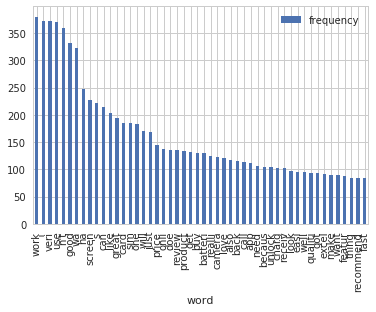

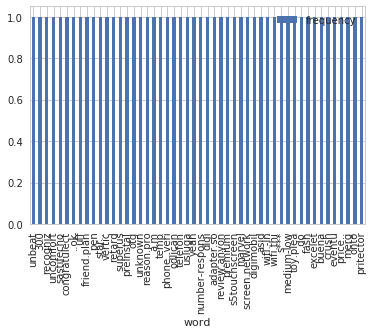

In [12]:
words = Counter()
data = loader(train_file_path,sample=True)
for i in data.index:
     tokens = ReviewTokenizer.tokenize(data['Reviews'].iat[i],stopwords)
     words.update(tokens)
    
mc = words.most_common(50)
df = pd.DataFrame(mc, columns=['word', 'frequency'])
df.plot(kind='bar', x='word')
print(mc)
lc = words.most_common()[-50:]
df = pd.DataFrame(lc, columns=['word', 'frequency'])
df.plot(kind='bar', x='word')
print(lc)

#### 2.3.7 Build dictionary

In [13]:
def create_bow(documents, features,stopwords,text_column='Reviews', label_columns='Rating'):
    row = []
    col = []
    data = []

    labels = []
    for i in documents.index:
        tokens = ReviewTokenizer.tokenize(documents[text_column].iat[i],stopwords)
        if label_columns is not False:
            labels.append(documents[label_columns].iat[i])
        for token in set(tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(documents), len(features))), labels

### 2.4 Analysis

#### 2.4.0 Word frequency

In [19]:
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

min_word_count = 10
def experiment(min_word_count,sample=True,predict=False):
    if not predict:
        data = loader(train_file_path,sample=sample)
        row_count = data.shape[0]
        split_point = int(row_count*1/5)
        test_data, train_data = data[:split_point], data[split_point:]
        test_data = test_data.reset_index(drop=True)
        train_data = train_data.reset_index(drop=True)
    else:
        train_data = loader(train_file_path, sample=sample)
        test_data = loader(test_file_path, sample=sample)
        

    words = Counter()
    for i in train_data.index:
         df = train_data['Reviews'].iat[i]
         tokens = ReviewTokenizer.tokenize(df,stopwords)
         words.update(tokens)


    common_words = list([k for k, v in words.most_common() if v > min_word_count])

    feature_dict = {}
    for word in common_words:
        feature_dict[word] = len(feature_dict)

    print("Training classifier...")
    
    X_train, y_train = create_bow(train_data, feature_dict,stopwords)
    list_of_labels = list(set(y_train))
    
    classifier = RandomForestClassifier(n_estimators=30, n_jobs=4, random_state=23)
    classifier.fit(X_train, y_train)

    print("Testing...")
    if not predict:
        X_test, y_test = create_bow(test_data, feature_dict,stopwords)
    else:
        X_test, y_test = create_bow(test_data, feature_dict,stopwords,label_columns=False)
    predicted = classifier.predict(X_test)
    rmsa = False
    if not predict:
        print("=================== Results ===================")
        print("            Positive    Neutral     Negative   ")
        print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
        print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
        print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
        errors = abs(predicted - y_test)
        print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
        rmsa = mean_squared_error(y_test, predicted)
        print("RMSA   ", rmsa)
    else:
        output = [];
        for i in test_data.index:
            _id = test_data['Id'].iat[i]
            pre = predicted[i]
            output.append((_id,pre))
        return output
    return rmsa,predicted


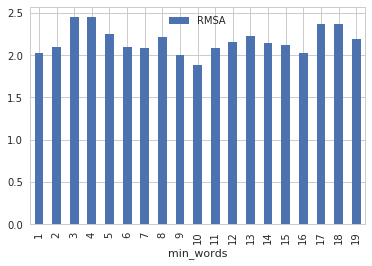

In [110]:

RMSA = []
for min_words in range(1,20):
    rmsa = experiment(min_words)
    RMSA.append((min_words,rmsa))

df = pd.DataFrame(RMSA, columns=['min_words', 'RMSA'])
df.plot(kind='bar', x='min_words')


In [24]:

experiment(10,True,False)

Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.43333333 0.16666667 0.19047619 0.10810811 0.76744186]
Precision [0.35135135 0.5        0.5        0.2        0.68275862]
Recall    [0.56521739 0.1        0.11764706 0.07407407 0.87610619]
Mean Absolute Error: 0.8 degrees.
RMSA    2.115


(2.115,
 array([5, 5, 4, 5, 5, 1, 2, 1, 5, 5, 5, 5, 5, 2, 1, 1, 5, 5, 5, 4, 2, 5,
        1, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5,
        5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 4, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 4, 5, 1, 5, 3, 5, 5,
        1, 5, 4, 1, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 4, 5, 5,
        1, 5, 5, 5, 1, 3, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 5, 1,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 1, 1, 5, 5, 5, 5,
        3, 5, 5, 5, 1, 5, 5, 4, 1, 5, 1, 5, 5, 5, 1, 5, 5, 5, 5, 5, 1, 5,
        1, 1, 5, 1, 5, 1, 1, 5, 5, 5, 5, 5, 3, 5, 5, 5, 2, 1, 4, 5, 1, 5,
        5, 1]))

In [23]:
import csv
data = experiment(10,True,False)
with open('submission.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['Id','Rating'])
    for row in data:
        csv_out.writerow(row)

Training classifier...
Testing...
